# Basic Dataset

In [1]:
import datetime
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [2]:
import sys
sys.path.append('/Users/macuser/Documents/trading/cryptobot/features')
import dataset, calendar_util

In [3]:
start_date = pd.to_datetime('2024-02-10')
end_date = pd.to_datetime('2025-03-31')
freq = '30min'
num_features = 20
model_train_freq = 'weekly'
train_lookback_days = 63
feature_cols = [f'ret_{i + 1}' for i in range(num_features)]
feature_cols += ['ema_7', 'ema_14', 'ema_21', 'ema_44', 'ema_50',
       'ema_63', 'ema_100', 'ema_132', 'ema_200', 'ema_256', 'supertrend_10_3',
       'supertrend_15_1', 'supertrend_10_2', 'supertrend_8_2',
       'supertrend_8_3', 'vwap', 'rsi_14', 'macd',]
label_col = 'Fwd_Ret'

In [4]:
from datetime import datetime, timedelta
import dataset  # assumes dataset.get(date) exists

        
def collect_data_train(symbol, start_date, end_date):
    collected_data = []
    current = start_date
    while current <= end_date:
        print('getting data for', current)
        try:
            data = dataset.train_data(symbol, current, freq, num_features)
            if data is not None:
                collected_data.append(data)
        except Exception as e:
            print(f"Error on {current}: {e}")
        current += timedelta(days=1)

    return pd.concat(collected_data)


import pandas as pd
from datetime import datetime
from typing import Union, Literal

def get_train_data(df,
                   target_date,
                   lookback_days,
                   lag = 1):
    """
    Uses get_training_dates to slice the training data from df.
    """
    target_date = pd.to_datetime(target_date).date()
    df['date'] = pd.to_datetime(df['timestamp']).dt.date

    training_dates = calendar_util.get_training_dates(target_date, lookback_days, lag=lag, frequency=model_train_freq)
    train_df = df[df['date'].isin(training_dates)]
    return train_df


In [ ]:
dataset_df = collect_data_train('BTCUSD', start_date, end_date)

In [6]:
print(dataset_df.columns)

Index(['ret_1', 'ret_2', 'ret_3', 'ret_4', 'ret_5', 'ret_6', 'ret_7', 'ret_8',
       'ret_9', 'ret_10', 'ret_11', 'ret_12', 'ret_13', 'ret_14', 'ret_15',
       'ret_16', 'ret_17', 'ret_18', 'ret_19', 'ret_20', 'timestamp',
       'fetch_timestamp', 'ema_7', 'ema_14', 'ema_21', 'ema_44', 'ema_50',
       'ema_63', 'ema_100', 'ema_132', 'ema_200', 'ema_256', 'supertrend_10_3',
       'supertrend_15_1', 'supertrend_10_2', 'supertrend_8_2',
       'supertrend_8_3', 'vwap', 'rsi_14', 'macd', 'Fwd_Ret'],
      dtype='object')


In [7]:
model_train_dates = sorted(list(set([calendar_util.get_last_training_date(dt, frequency = model_train_freq) for dt in pd.date_range(start=start_date, end=end_date, freq='D')])))

In [ ]:
model_prediction_dates = {}

for i, train_date in enumerate(model_train_dates):
    # Determine the start of prediction (day after training)
    pred_start = train_date

    # Determine the end of prediction
    if i + 1 < len(model_train_dates):
        pred_end = model_train_dates[i + 1]
    else:
        pred_end = end_date + pd.Timedelta(days=1)  # include last day

    # Generate prediction date range (exclude train_date itself)
    pred_dates = pd.date_range(start=pred_start, end=pred_end - pd.Timedelta(days=1), freq='D')

    model_prediction_dates[train_date] = pred_dates
print(model_prediction_dates)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Store forward prediction results
forward_predictions = {}

for train_date in model_train_dates:
    print(f"\nTraining model for {train_date}")

    # In-sample training data
    train_data = get_train_data(dataset_df, train_date, train_lookback_days, lag=1)
    # Replace inf/-inf with NaN, then fill NaNs with 0 or any other strategy
    train_data = train_data.replace([np.inf, -np.inf], np.nan).fillna(0)

    X_train = train_data[feature_cols]
    y_train = train_data[label_col]

    if X_train.empty or y_train.empty:
        print("No training data found. Skipping...")
        continue

    # Train model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # In-sample prediction and stats
    y_pred_train = model.predict(X_train)
    r2 = r2_score(y_train, y_pred_train)
    mse = mean_squared_error(y_train, y_pred_train)
    mae = mean_absolute_error(y_train, y_pred_train)

    print(f"In-sample R² Score: {r2:.10f}")
    print(f"In-sample MSE     : {mse:.10f}")
    print(f"In-sample MAE     : {mae:.10f}")

    # ---- OOS / Forward Predictions ----
    pred_dates = model_prediction_dates[train_date]
    if pred_dates.empty:
        continue

    import pytz

    # Define your timezone
    ASIA_TZ = 'Asia/Kolkata'
    
    # Make pred_dates timezone-aware
    pred_dates = pred_dates.tz_localize(ASIA_TZ)
    
    # Now safely compare
    mask = (dataset_df['timestamp'] >= pred_dates.min()) & (dataset_df['timestamp'] <= pred_dates.max())
    pred_df = dataset_df[mask].copy()
    # Replace inf/-inf with NaN, then fill NaNs with 0 or any other strategy
    pred_df = pred_df.replace([np.inf, -np.inf], np.nan).fillna(0)

    if pred_df.empty:
        print("No data available for forward prediction window.")
        continue

    X_pred = pred_df[feature_cols]
    y_true = pred_df[label_col] if label_col in pred_df else None

    y_pred = model.predict(X_pred)

    # Save predictions
    forward_predictions[train_date] = {
        "dates": pred_df['timestamp'].values,
        "predictions": y_pred,
        "true": y_true.values if y_true is not None else None
    }

    # Optionally print or evaluate OOS performance if ground truth is available
    if y_true is not None and not y_true.isnull().all():
        r2_oos = r2_score(y_true, y_pred)
        mse_oos = mean_squared_error(y_true, y_pred)
        mae_oos = mean_absolute_error(y_true, y_pred)

        print(f"OOS R² Score: {r2_oos:.10f}")
        print(f"OOS MSE     : {mse_oos:.10f}")
        print(f"OOS MAE     : {mae_oos:.10f}")
    else:
        print("Ground truth not available for OOS window.")


In [10]:
# Collect all prediction results
all_preds = []

for train_date, result in forward_predictions.items():
    dates = result["dates"]
    preds = result["predictions"]
    true_vals = result["true"]

    # Build a temporary DataFrame for each train_date
    temp_df = pd.DataFrame({
        'timestamp': dates,
        'prediction': preds,
        'fwd_ret': true_vals
    })
    temp_df['timestamp'] = pd.to_datetime(temp_df['timestamp']).dt.tz_localize('Asia/Kolkata')

    # Merge with original dataset to bring in features
    merged_df = pd.merge(temp_df, dataset_df[['timestamp'] + feature_cols], on='timestamp', how='left')

    # Append to final list
    all_preds.append(merged_df)

# Combine all into a single DataFrame
final_prediction_df = pd.concat(all_preds, ignore_index=True)

# Optional: sort by timestamp
final_prediction_df = final_prediction_df.sort_values(by='timestamp').reset_index(drop=True)



In [11]:
final_prediction_df['return'] = np.sign(final_prediction_df['prediction']) * final_prediction_df['fwd_ret']

In [12]:
final_prediction_df['Hit'] = np.sign(final_prediction_df['prediction']) * np.sign(final_prediction_df['fwd_ret'])

In [13]:
len(final_prediction_df[final_prediction_df['Hit'] > 0])/len(final_prediction_df)

0.5078125

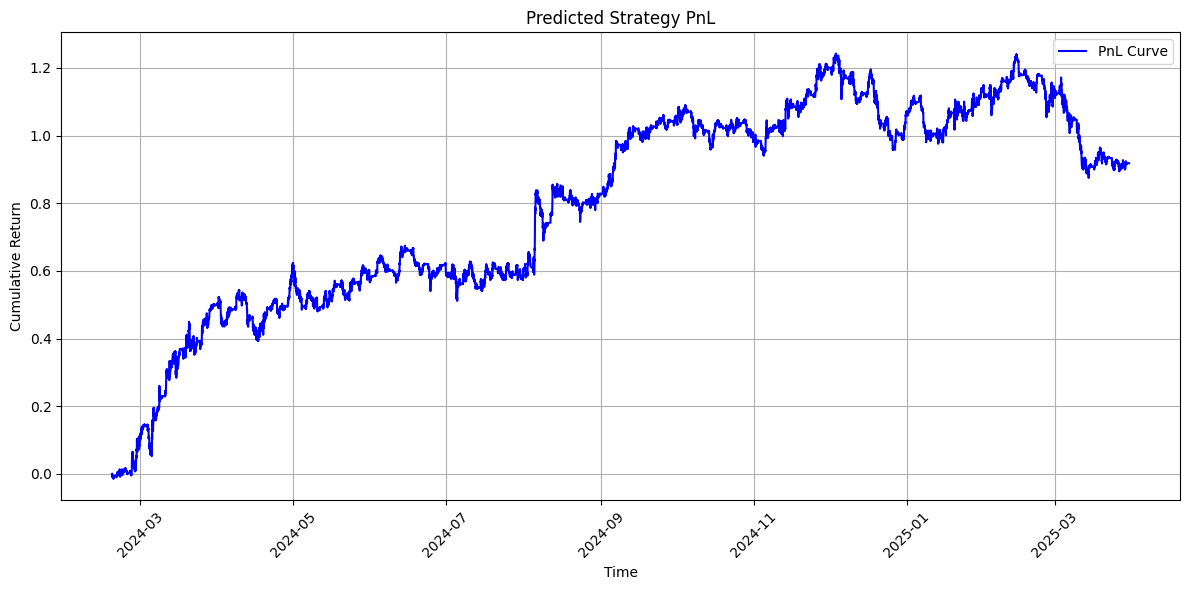

In [14]:
import matplotlib.pyplot as plt
import pandas as pd

# Optional: Ensure DataFrame is sorted by time
final_prediction_df = final_prediction_df.sort_values(by='timestamp')

# Calculate cumulative returns
final_prediction_df['cumulative_return'] = final_prediction_df['return'].cumsum()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(final_prediction_df['timestamp'], final_prediction_df['cumulative_return'], label='PnL Curve', color='blue')

# Formatting
plt.xlabel('Time')
plt.ylabel('Cumulative Return')
plt.title('Predicted Strategy PnL')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()
